In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import os
import sys

sys.path.append("..")
sys.path.append("../..")

import numpy as np 
import pandas as pd

### Occupancy data

In [3]:
## [from examples/examples.py]
from download import download_all 

## The path to the test data sets
FIXTURES  = os.path.join(os.getcwd(), "data")

## Dataset loading mechanisms
datasets = {
    "credit": os.path.join(FIXTURES, "credit", "credit.csv"),
    "concrete": os.path.join(FIXTURES, "concrete", "concrete.csv"),
    "occupancy": os.path.join(FIXTURES, "occupancy", "occupancy.csv"),
    "mushroom": os.path.join(FIXTURES, "mushroom", "mushroom.csv"),
}

def load_data(name, download=True):
    """
    Loads and wrangles the passed in dataset by name.
    If download is specified, this method will download any missing files. 
    """
    # Get the path from the datasets 
    path = datasets[name]
    
    # Check if the data exists, otherwise download or raise 
    if not os.path.exists(path):
        if download:
            download_all() 
        else:
            raise ValueError((
                "'{}' dataset has not been downloaded, "
                "use the download.py module to fetch datasets"
            ).format(name))
    
    # Return the data frame
    return pd.read_csv(path)

In [4]:
# Load the classification data set
data = load_data('occupancy') 
print(len(data))
data.head()

20560


,datetime,temperature,relative humidity,light,C02,humidity,occupancy
0,2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
1,2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
2,2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
3,2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
4,2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


In [5]:
# Specify the features of interest and the classes of the target 
features = ["temperature", "relative humidity", "light", "C02", "humidity"]
classes = ['unoccupied', 'occupied']

# Searching the whole dataset takes a while (15 mins on my mac)... 
# For demo purposes, we reduce the size
X = data[features].head(2000)
y = data.occupancy.head(2000)

### Parameter projection

* Because the visualizer only displays results across two parameters, we need some way of reducing the dimension to 2. 
* Our approach: for each value of the parameters of interest, display the _maximum_ score across all the other parameters.

Here we demo the `param_projection` utility function that does this

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

from yellowbrick.gridsearch.base import param_projection

/Users/pschafer/.pyenv/versions/3.6.2/envs/yellowbrick/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
# Fit a vanilla grid search... these are the example parameters from sklearn's gridsearch docs.
svc = SVC()
grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4], 'C': [1, 10, 100, 1000]},
        {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
gs = GridSearchCV(svc, grid, n_jobs=4)

In [8]:
%%time
gs.fit(X, y)

CPU times: user 147 ms, sys: 28.2 ms, total: 175 ms
Wall time: 31 s


GridSearchCV(cv=None, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=4,
       param_grid=[{'kernel': ['rbf'], 'gamma': [0.001, 0.0001], 'C': [1, 10, 100, 1000]}, {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

As of Scikit-learn 0.18, `cv_results` has replaced `grid_scores` as the grid search results format

In [9]:
gs.cv_results_

/Users/pschafer/.pyenv/versions/3.6.2/envs/yellowbrick/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/pschafer/.pyenv/versions/3.6.2/envs/yellowbrick/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
/Users/pschafer/.pyenv/versions/3.6.2/envs/yellowbrick/lib/python3.6/site-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set retu

{'mean_fit_time': array([0.02446747, 0.01360734, 0.02218564, 0.00889039, 0.02143168,
        0.0146842 , 0.03453048, 0.02234364, 1.94032502, 3.24313124,
        4.1275959 , 3.99856925]),
 'mean_score_time': array([0.00456238, 0.00284052, 0.00362539, 0.00334334, 0.00262896,
        0.00233173, 0.00262411, 0.00177709, 0.0011073 , 0.00116841,
        0.00101606, 0.00154575]),
 'mean_test_score': array([0.895 , 0.891 , 0.9055, 0.8995, 0.8995, 0.914 , 0.9045, 0.9185,
        0.915 , 0.9135, 0.9105, 0.9115]),
 'mean_train_score': array([0.9847535 , 0.97950518, 0.990002  , 0.98125506, 0.99450106,
        0.98475368, 0.99625056, 0.99275119, 0.96525668, 0.96550693,
        0.96525687, 0.96500699]),
 'param_C': masked_array(data=[1, 1, 10, 10, 100, 100, 1000, 1000, 1, 10, 100, 1000],
              mask=[False, False, False, False, False, False, False, False,
                    False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_gamma': masked_array(data=[0.0

Demo the use of param_projection... It identifies the unique values of the the two parameter values and gets the best score for each (here taking the max over `gamma` values)

In [10]:
param_1 = 'C'
param_2 = 'kernel'
param_1_vals, param2_vals, best_scores = param_projection(gs.cv_results_, param_1, param_2)
param_1_vals, param2_vals, best_scores

([1, 10, 100, 1000],
 ['linear', 'rbf'],
 array([[0.915 , 0.9135, 0.9105, 0.9115],
        [0.895 , 0.9055, 0.914 , 0.9185]]))

### GridSearchColorPlot

This visualizer wraps the GridSearchCV object and plots the values obtained from `param_projection`.

In [11]:
from yellowbrick.gridsearch import GridSearchColorPlot

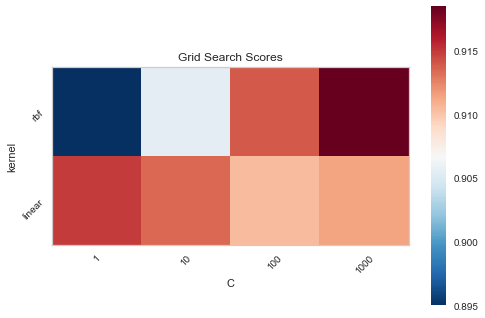

In [12]:
gs_viz = GridSearchColorPlot(gs, 'C', 'kernel')
gs_viz.fit(X, y).show()

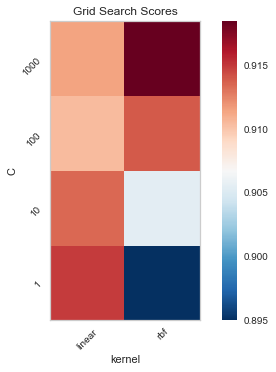

In [13]:
gs_viz = GridSearchColorPlot(gs, 'kernel', 'C')
gs_viz.fit(X, y).show()

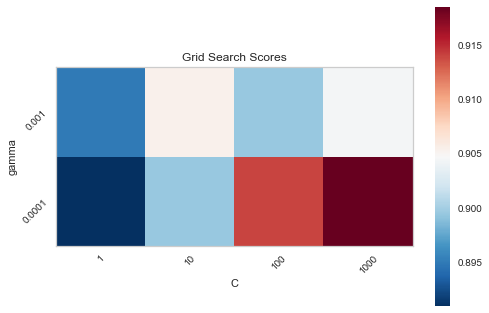

In [14]:
gs_viz = GridSearchColorPlot(gs, 'C', 'gamma')
gs_viz.fit(X, y).show()

If there are missing values in the grid, these are filled with a hatch (see https://stackoverflow.com/a/35905483/7637679)

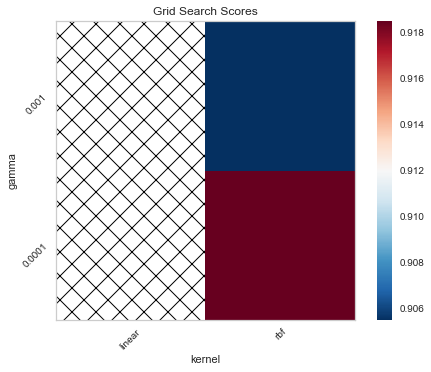

In [15]:
gs_viz = GridSearchColorPlot(gs, 'kernel', 'gamma')
gs_viz.fit(X, y).show()

Choose a different metric...

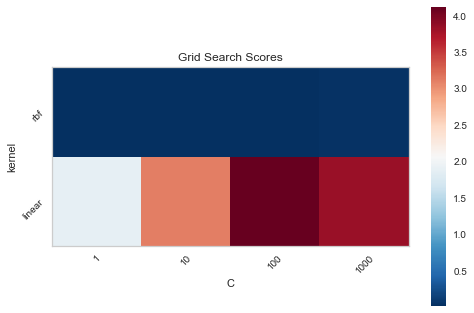

In [16]:
gs_viz = GridSearchColorPlot(gs, 'C', 'kernel', metric='mean_fit_time')
gs_viz.fit(X, y).show()

### Quick Method

Because grid search can take a long time and we may want to interactively cut the results a few different ways, by default the quick method assumes that the GridSearchCV object is **already fit** if no X data is passed in. 

In [17]:
from yellowbrick.gridsearch import gridsearch_color_plot

CPU times: user 84.1 ms, sys: 2.95 ms, total: 87.1 ms
Wall time: 87.4 ms


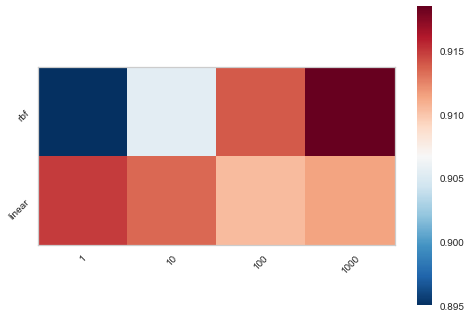

In [18]:
%%time
# passing the GridSearchCV object pre-fit
gridsearch_color_plot(gs, 'C', 'kernel')

CPU times: user 73.3 ms, sys: 3.95 ms, total: 77.2 ms
Wall time: 79.8 ms


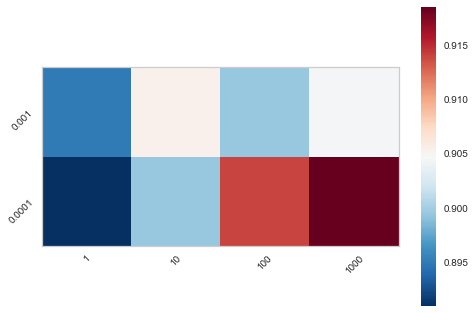

In [19]:
%%time
# trying a different cut across parameters
gridsearch_color_plot(gs, 'C', 'gamma')

CPU times: user 206 ms, sys: 35.1 ms, total: 241 ms
Wall time: 31 s


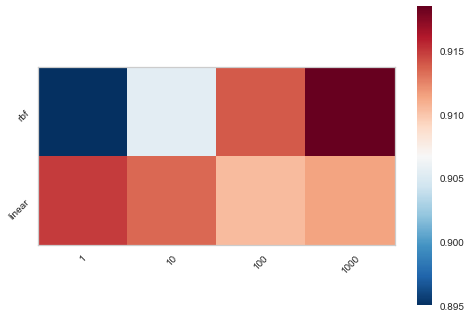

In [20]:
%%time
# When we provide X, the `fit` method will call fit (takes longer)
gridsearch_color_plot(gs, 'C', 'kernel', X=X, y=y)

CPU times: user 67.5 ms, sys: 3.4 ms, total: 70.9 ms
Wall time: 77.7 ms


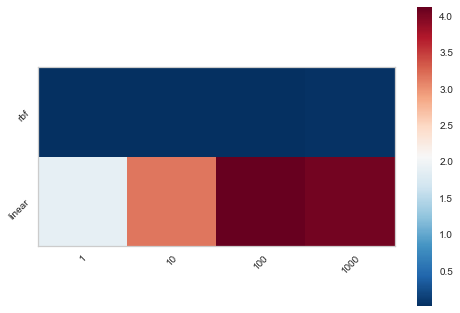

In [21]:
%%time
# can also choose a different metric
gridsearch_color_plot(gs, 'C', 'kernel', metric='mean_fit_time')

### Parameter errors

Bad param values

In [22]:
gs_viz = GridSearchColorPlot(gs, 'foo', 'kernel')
gs_viz.fit(X, y).show()

YellowbrickKeyError: "Parameter 'foo' does not exist in the grid search results"

In [23]:
gs_viz = GridSearchColorPlot(gs, 'C', 'foo')
gs_viz.fit(X, y).show()

YellowbrickKeyError: "Parameter 'foo' does not exist in the grid search results"

Bad metric option

In [24]:
gs_viz = GridSearchColorPlot(gs, 'C', 'kernel', metric='foo')
gs_viz.fit(X, y).show()

YellowbrickKeyError: "Metric 'foo' does not exist in the grid search results"

Metric option exists in cv_results but is not numeric -> not valid

In [25]:
gs_viz = GridSearchColorPlot(gs, 'C', 'kernel', metric='param_kernel')
gs_viz.fit(X, y).show()

YellowbrickValueError: Cannot display grid search results for metric 'param_kernel': result values may not all be numeric